Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
## from google.colab import drive
## drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

## Data Reading/Data Understanding

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

#### The paths for both train and test images from dataset.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("./data/Train/")
data_dir_test = pathlib.Path('./data/Test/')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

#### Train & validation dataset from the train directory with a batch size of 32
#### Resized images to 180*180.(10%)

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [9]:
type(train_ds)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [10]:
print(type(train_ds))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


In [11]:
for images, labels in train_ds.take(1):
    print(len(images))
    print(len(labels))

32
32


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

32
32


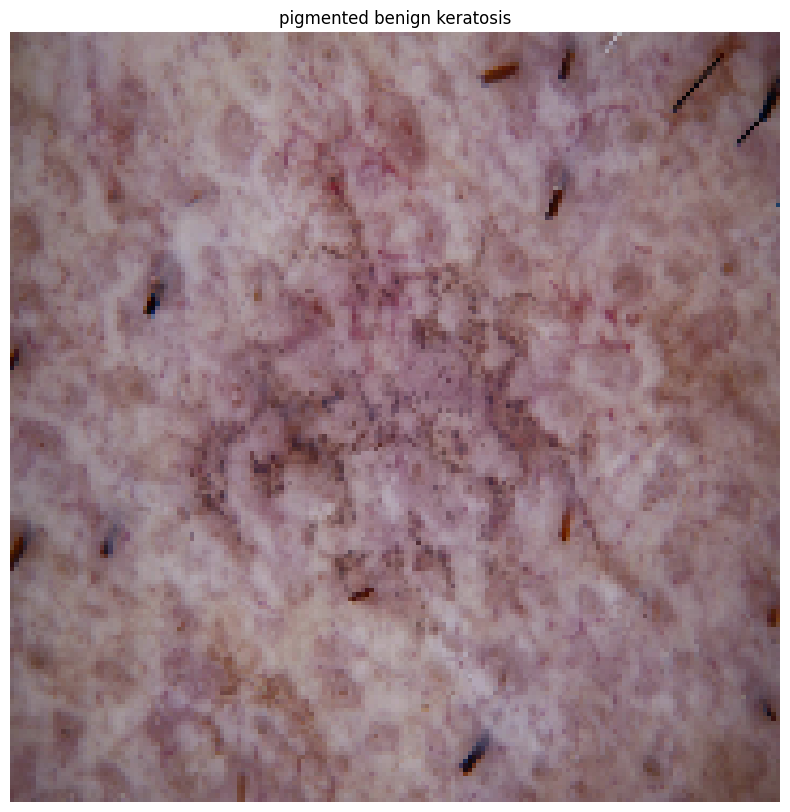

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(len(images))
    print(len(labels))
    plt.imshow(images[10].numpy().astype("uint8"))
    plt.title(class_names[labels[10]])
    plt.axis("off")

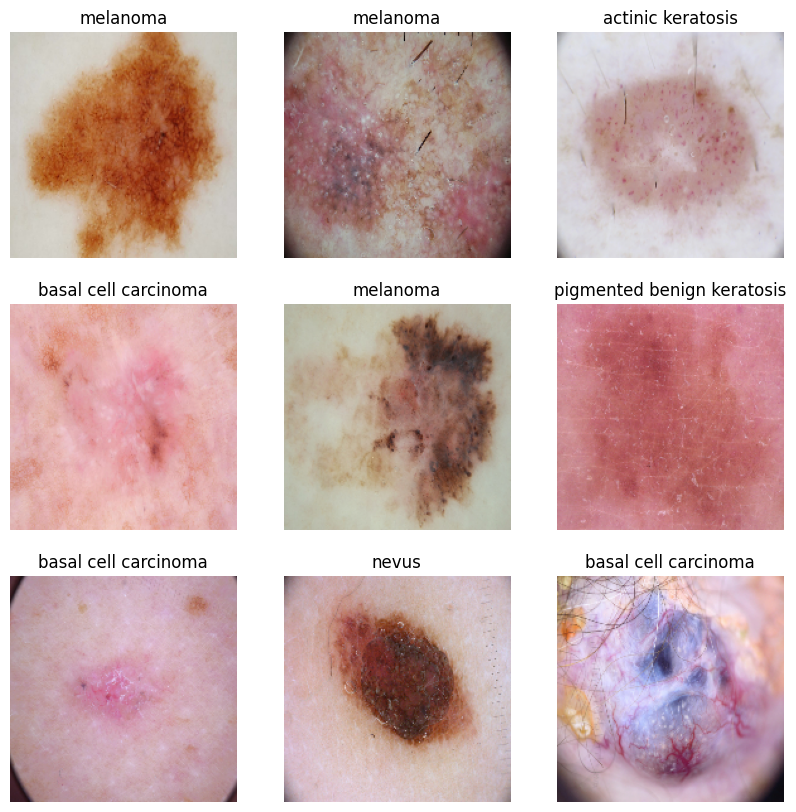

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(5):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
### Your code goes here
num_classes = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(16, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input.
  layers.MaxPooling2D(),

  #We slide over the feature map and extract tiles of a specified size.
  layers.Conv2D(32, 3, padding='same', activation='relu'),

  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size.
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer
  #A hidden layer in which each node is connected to every node in the subsequent hidden layer.
  #A fully connected layer is also known as a dense layer.

  layers.Dense(128, activation='relu'),

  #Dense is the only actual network layer in that model. A Dense layer feeds all outputs from the previous layer to all its neurons, each neuron providing one output to the next layer.
  #It's the most basic layer in neural networks. A Dense(10) has ten neurons. A Dense(512) has 512 neurons.
  #Dense implements the operation: output = activation(dot(input, kernel)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

In [19]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


56/56 [==============================] - 15s 189ms/step - loss: 2.0056 - accuracy: 0.2427 - val_loss: 2.1903 - val_accuracy: 0.2288
Epoch 2/20
56/56 [==============================] - 8s 147ms/step - loss: 1.6743 - accuracy: 0.4096 - val_loss: 2.4498 - val_accuracy: 0.2373
Epoch 3/20
56/56 [==============================] - 8s 149ms/step - loss: 1.4781 - accuracy: 0.4732 - val_loss: 2.4933 - val_accuracy: 0.2288
Epoch 4/20
56/56 [==============================] - 8s 143ms/step - loss: 1.3192 - accuracy: 0.5374 - val_loss: 2.1043 - val_accuracy: 0.2542
Epoch 5/20
56/56 [==============================] - 8s 140ms/step - loss: 1.2407 - accuracy: 0.5580 - val_loss: 2.5816 - val_accuracy: 0.2712
Epoch 6/20
56/56 [==============================] - 8s 140ms/step - loss: 1.1829 - accuracy: 0.5798 - val_loss: 2.8783 - val_accuracy: 0.2797
Epoch 7/20
56/56 [==============================] - 8s 144ms/step - loss: 1.1032 - accuracy: 0.6071 - val_loss: 2.7423 - val_accuracy: 0.3136
Epo

### Visualizing training results

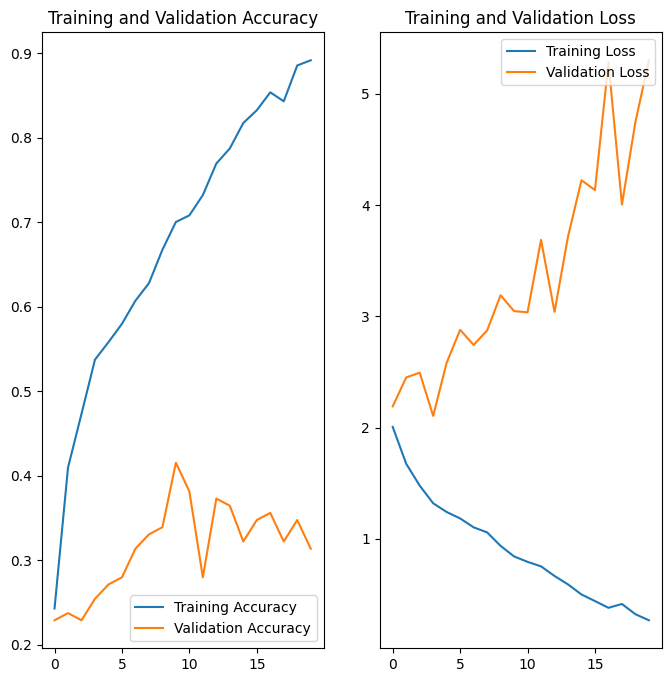

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  #We slide over the feature map and extract tiles of a specified size.
  layers.MaxPooling2D(),
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.Flatten(),
  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  layers.Dense(128, activation='relu'),
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
  layers.Dense(num_classes)
  #Dense Layer - A dense layer represents a matrix vector multiplication.  each input node is connected to each output node.
])

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

Yes the model is overfitting

### Write your findings here



The model is overfitting, hence we are attampting augmentation method

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                                                 input_shape=(img_height,
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

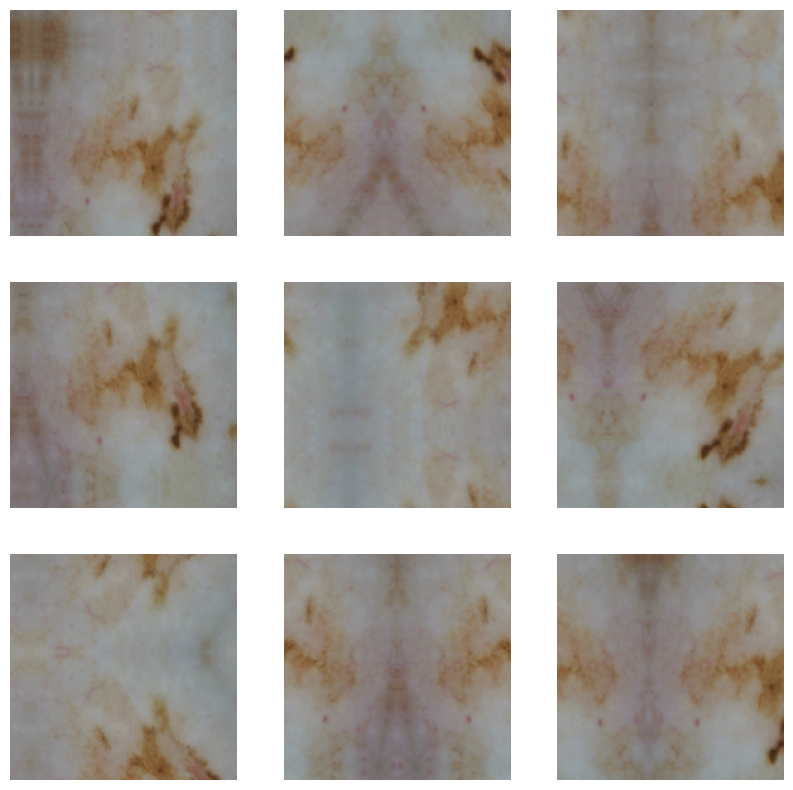

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [24]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Compiling the model

In [25]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [26]:
## Your code goes here
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 72s 1s/step - loss: 2.3289 - accuracy: 0.2366 - val_loss: 2.2508 - val_accuracy: 0.1949
Epoch 2/20
56/56 [==============================] - 67s 1s/step - loss: 1.7708 - accuracy: 0.3287 - val_loss: 2.1203 - val_accuracy: 0.1864
Epoch 3/20
56/56 [==============================] - 68s 1s/step - loss: 1.6825 - accuracy: 0.3655 - val_loss: 2.0736 - val_accuracy: 0.2034
Epoch 4/20
56/56 [==============================] - 68s 1s/step - loss: 1.6707 - accuracy: 0.3733 - val_loss: 2.5742 - val_accuracy: 0.2373
Epoch 5/20
56/56 [==============================] - 70s 1s/step - loss: 1.6912 - accuracy: 0.3655 - val_loss: 2.3188 - val_accuracy: 0.1949
Epoch 6/20
56/56 [==============================] - 67s 1s/step - loss: 1.6643 - accuracy: 0.3728 - val_loss: 2.1744 - val_accuracy: 0.1864
Epoch 7/20
56/56 [==============================] - 69s 1s/step - loss: 1.6253 - accuracy: 0.3828 - val_loss: 2.5496 - val_accuracy: 0.2288
Epoch 8/20
56/56 [==

### Visualizing the results

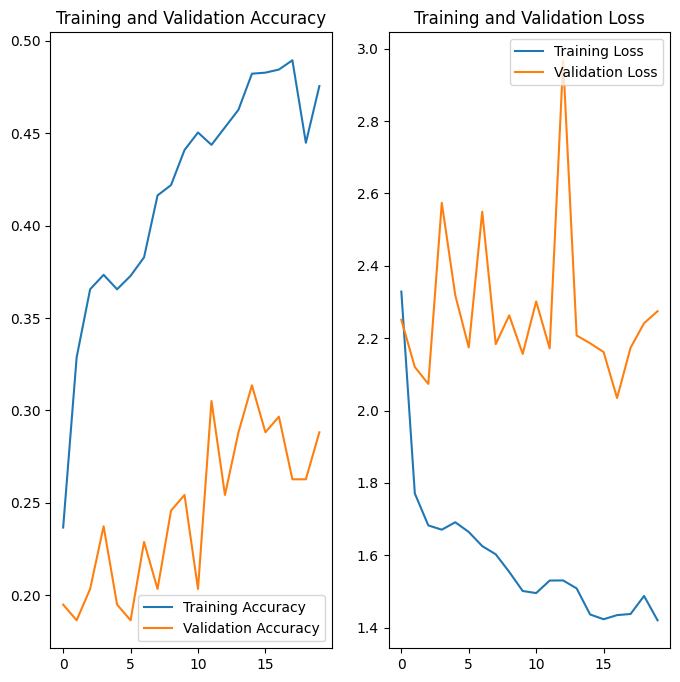

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
## Your code goes here.
train_dir = os.path.join('./data/Train')
val_dir = os.path.join('./data/Test')

In [29]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Setting batch size and image size
batch_size = 100
IMG_SHAPE = 224

image_gen_train = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=45,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.5
                    )

train_data_gen = image_gen_train.flow_from_directory(
                                                batch_size=batch_size,
                                                directory=train_dir,
                                                shuffle=True,
                                                target_size=(IMG_SHAPE,IMG_SHAPE),
                                                class_mode='sparse'
                                                )

# Create validation images generator
image_gen_val = ImageDataGenerator(rescale=1./255)
val_data_gen = image_gen_val.flow_from_directory(batch_size=batch_size,
                                                 directory=val_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='sparse')

Found 2239 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [30]:
#Create a CNN model
#Experiment #1
#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt

# Import layers explicitly to keep our code compact
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D


model = Sequential()

model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_SHAPE,IMG_SHAPE, 3)))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, 3, padding='same', activation='relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))

model.add(Dropout(0.2))

model.add(Dense(9))

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
epochs = 20

history = model.fit(
  train_data_gen,
  validation_data=val_data_gen,
  epochs=10
)

Epoch 1/10
23/23 [==============================] - 85s 4s/step - loss: 2.4840 - accuracy: 0.2229 - val_loss: 2.2228 - val_accuracy: 0.1864
Epoch 2/10
23/23 [==============================] - 61s 3s/step - loss: 1.8954 - accuracy: 0.2863 - val_loss: 2.1621 - val_accuracy: 0.2034
Epoch 3/10
23/23 [==============================] - 57s 2s/step - loss: 1.7194 - accuracy: 0.3586 - val_loss: 2.3696 - val_accuracy: 0.2542
Epoch 4/10
23/23 [==============================] - 65s 3s/step - loss: 1.7050 - accuracy: 0.4100 - val_loss: 2.0815 - val_accuracy: 0.3051
Epoch 5/10
23/23 [==============================] - 63s 3s/step - loss: 1.6256 - accuracy: 0.4194 - val_loss: 2.2704 - val_accuracy: 0.3051
Epoch 6/10
23/23 [==============================] - 61s 3s/step - loss: 1.5206 - accuracy: 0.4636 - val_loss: 2.2379 - val_accuracy: 0.3136
Epoch 7/10
23/23 [==============================] - 59s 3s/step - loss: 1.4984 - accuracy: 0.4596 - val_loss: 2.1911 - val_accuracy: 0.3051
Epoch 8/10
23/23 [==

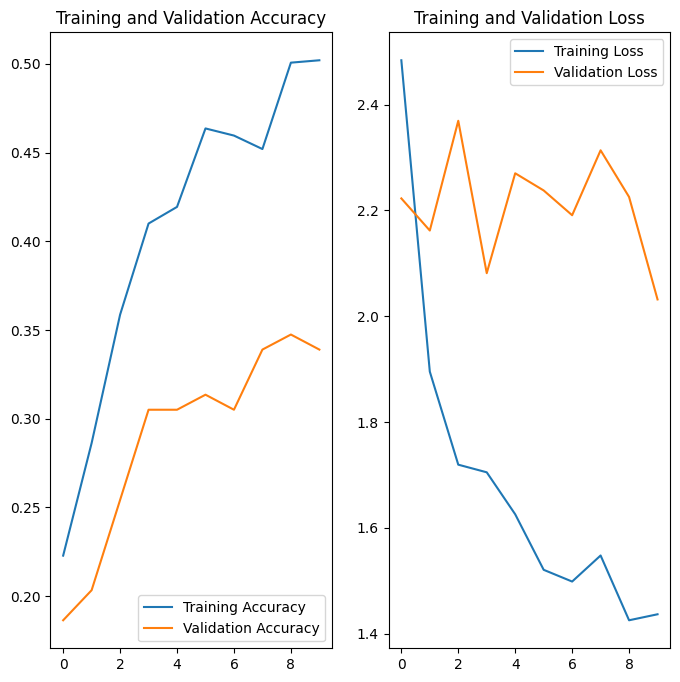

In [31]:
import matplotlib.pyplot as plt
epochs=10
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
seborrheic keratosis

#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis

In [32]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
len(path_list)

2239

In [33]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,data\Train\actinic keratosis\ISIC_0025780.jpg,actinic keratosis
1,data\Train\actinic keratosis\ISIC_0025803.jpg,actinic keratosis
2,data\Train\actinic keratosis\ISIC_0025825.jpg,actinic keratosis
3,data\Train\actinic keratosis\ISIC_0025953.jpg,actinic keratosis
4,data\Train\actinic keratosis\ISIC_0025957.jpg,actinic keratosis
...,...,...
2234,data\Train\vascular lesion\ISIC_0033844.jpg,vascular lesion
2235,data\Train\vascular lesion\ISIC_0033969.jpg,vascular lesion
2236,data\Train\vascular lesion\ISIC_0033991.jpg,vascular lesion
2237,data\Train\vascular lesion\ISIC_0034196.jpg,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


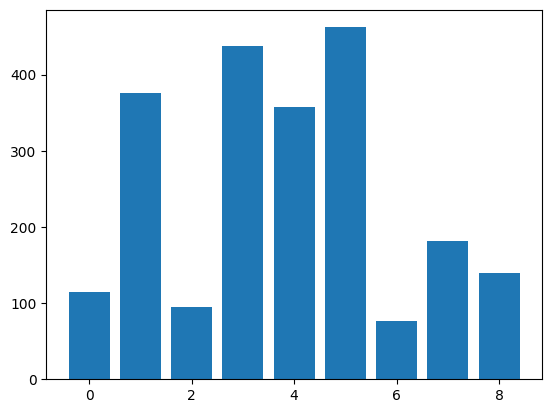

In [34]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter
# split into input and output elements
X, y = original_df['Path'], original_df['Label']
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [35]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [36]:
path_to_training_dataset="./data/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to ./data/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B14C4CA3B0>: 100%|█| 500/500 [00:04<00:00, 123.63 Samples


Initialised with 376 image(s) found.
Output directory set to ./data/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B1B4F6CA60>: 100%|█| 500/500 [00:04<00:


Initialised with 95 image(s) found.
Output directory set to ./data/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B1B4F80DF0>: 100%|█| 500/500 [00:04<00:00, 102.95 Samples


Initialised with 438 image(s) found.
Output directory set to ./data/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B1B5055630>: 100%|█| 500/500 [00:23<00:00, 21.47 Samples


Initialised with 357 image(s) found.
Output directory set to ./data/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x1B1B4F80AF0>: 100%|█| 500/500 [00:22<00:00, 21.83 Sample


Initialised with 462 image(s) found.
Output directory set to ./data/Train/pigmented benign keratosis\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B1B502D540>: 100%|█| 500/500 [00:04<00:


Initialised with 77 image(s) found.
Output directory set to ./data/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1B14C4CBD60>: 100%|█| 500/500 [00:10<00:00, 45.56 Samples


Initialised with 181 image(s) found.
Output directory set to ./data/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1B1B5057D60>: 100%|█| 500/500 [00:04<00:


Initialised with 139 image(s) found.
Output directory set to ./data/Train/vascular lesion\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1B1B4ECB1C0>: 100%|█| 500/500 [00:04<00:00, 104.64 Samples


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [37]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [38]:
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

['data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_0a291fc5-d595-41f7-9784-cf754fdc07fe.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_3855cf00-00c6-4f77-b19c-003b17c6feae.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_769382ef-57a9-4b22-8bf8-717adf8201ac.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_a28b52dd-1e09-421f-b013-d490e5895727.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d6e36970-469a-4564-a0b7-5c4ac2098297.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_d943d9f5-04e6-414f-9f6f-c1b01005cc42.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_911dc92e-8ff4-468b-a338-4f292fd7a788.jpg',
 'data\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025825.jpg_8ec6c440-b9

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])


In [42]:
df2['Label'].value_counts()

Label
actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [44]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [45]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.
Using 23 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [46]:
## your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [47]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [48]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 40s 223ms/step - loss: 1.6307 - accuracy: 0.4299 - val_loss: 2.1132 - val_accuracy: 0.2174
Epoch 2/20
169/169 [==============================] - 32s 185ms/step - loss: 1.0510 - accuracy: 0.6217 - val_loss: 2.0019 - val_accuracy: 0.3043
Epoch 3/20
169/169 [==============================] - 31s 179ms/step - loss: 0.6911 - accuracy: 0.7576 - val_loss: 3.0650 - val_accuracy: 0.1739
Epoch 4/20
169/169 [==============================] - 31s 181ms/step - loss: 0.4632 - accuracy: 0.8359 - val_loss: 3.7052 - val_accuracy: 0.3043
Epoch 5/20
169/169 [==============================] - 31s 179ms/step - loss: 0.3069 - accuracy: 0.8932 - val_loss: 4.5717 - val_accuracy: 0.1739
Epoch 6/20
169/169 [==============================] - 32s 185ms/step - loss: 0.2594 - accuracy: 0.9101 - val_loss: 4.6496 - val_accuracy: 0.3478
Epoch 7/20
169/169 [==============================] - 31s 180ms/step - loss: 0.2207 - accuracy: 0.9256 - val_loss: 4.5290 - val_ac

#### **Todo:**  Visualize the model results

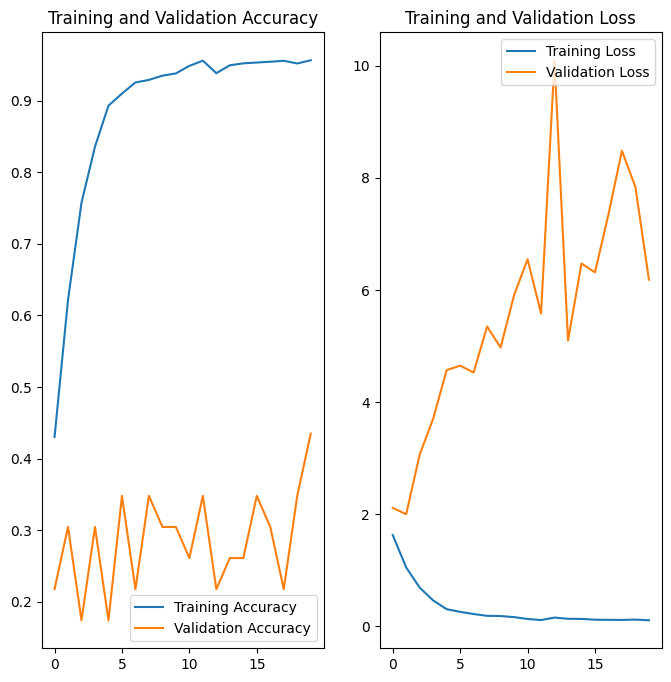

In [49]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



In [50]:
accuracy = model.evaluate(val_ds)
print(f'Test accuracy: {round(accuracy[1], 2)}')

1/1 [==============================] - 1s 639ms/step - loss: 6.1842 - accuracy: 0.4348
Test accuracy: 0.43


- Model is still overfitting
- The problem of overfitting can be solved by add more layer,neurons or adding dropout layers.
- The Model can be further improved by tuning the hyperparameter
- Augmentation process helps to reduce the overfitting
- Balancing out helps to an extent
- Accuracy on training data has increased by using Augmentor library
- To increase the accuracy of unseen data we may need more data/ images to get trained